# Global Variable (Edit Before you Run on your own)

In [1]:
EPOCHS_SIZE = 30 #Adjusted for trial first
BATCH_SIZE = 128
MODEL_SAVE_NAME = "digit_symbol_model_v2_with_30epochs" #change this so that u dont overwrite saved model
LOADED_MODEL_NAME = "" #Edit this one below

## Pre requisites that you need to install before use

#Just Run Once
!pip install tensorflow
!pip install scikit-learn
!pip install keras
!pip install keras-tuner
!pip install matplotlib
!pip install opencv-python
!pip install scipy

## 1. Imports

In [2]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import seaborn as sns

Using TensorFlow backend


## 2. Loading The Picture

In [3]:
def pre_processing_from_dir(dataset_dir, class_labels_dict, training=False):
    # Initialize lists to store images and labels
    images = []
    labels = []
    class_labels = []

    # Get a list of all subdirectories (each subdirectory represents a class)
    class_directories = os.listdir(dataset_dir)

    # Iterate through each subdirectory (class directory)
    for class_directory in class_directories:
        class_label = class_directory  # Use the directory name as the class label
        
        class_labels.append(class_label)
        class_path = os.path.join(dataset_dir, class_directory)

        # Get a list of image files in the class directory
        image_files = glob.glob(os.path.join(class_path, "*.jpg"))  # You may need to adjust the file extension

        # print(image_files)

        # Iterate through image files in the class directory
        for image_file in image_files:
            # Load and preprocess the image
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values

            # plt.imshow(image, cmap=plt.cm.binary)

            # Append the preprocessed image and its label to the lists
            images.append(image)
            labels.append(class_label)

    if training:

        data = list(zip(images, labels))

        # Shuffle the combined data
        np.random.shuffle(data)

        # shuffle the training images
        shuffled_images, shuffled_labels = zip(*data)

        images = np.array(shuffled_images)

        label_encoder = LabelEncoder()

        # Encode class labels using LabelEncoder
        labels = label_encoder.fit_transform(shuffled_labels)

        for i in range(len(class_labels)):
            class_labels_dict[class_labels[i]] = i

        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels, class_labels_dict

    else:
       
        # Convert lists to NumPy arrays
        images = np.array(images)

        # label-encoding done on test data should correspond to the ones in training data
        # this is to account for times when test data is lesser than training data

        for i in range(len(labels)):
            labels[i] = class_labels_dict[labels[i]]

        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels_dict)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels

In [4]:
images, labels, training_class_labels, class_labels_dict = pre_processing_from_dir("dataset/train", {}, True)

KeyboardInterrupt: 

### 2.2 Exploratory Data Analysis

### Data Augmentation on Training Data 
- random rotation
- random noise

In [ ]:
def data_augmentation(image):

    ##############################################################
    # Rotating images to mimic slanted handwriting

    # Convert the image to a NumPy array (assuming it's in the range [0, 1])
    image = (image * 255).astype(np.uint8)

    # Calculate the image center
    center = tuple(np.array(image.shape[1::-1]) / 2)

    rotation_angle = random.uniform(-30, 30)

    # Create a rotation matrix and apply the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))

    # Convert back to the range [0, 1]
    rotated_image = rotated_image.astype(np.float32) / 255.0

    ##############################################################
    # Adding random noise to mimic low quality images

    max_noise_level = random.uniform(0, 0.1)
    noise = tf.random.normal(shape=tf.shape(rotated_image), stddev=max_noise_level)
    
    return tf.clip_by_value(rotated_image + noise, 0.0, 1.0)


## 3. Defining The Model

In [5]:
from keras import callbacks

#Define callback functions. Change model_name, patience, as needed.
# keras_callbacks   = [
#       callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001),
#       callbacks.ModelCheckpoint('model_name', monitor='val_loss', save_best_only=True, mode='min')

def math_model(images, labels, num_classes, model_name):

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # perform data augmentation on X_train
    X_train = np.array([data_augmentation(image) for image in X_train])

    # Define your CNN model for multi-class classification

    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    # for one-hot encoding
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # uncomment this if using label-encoding, & comment the one above
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fit model. (Batch size either 32, 64, 128. 1000 epochs as we expect training to stop before that.
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS_SIZE, validation_data=(X_test, y_test))

    # Save the trained model for later use
    model.save(f"{model_name}.keras")

    # not a must to return history here but it's to see whether model is overfitting or underfitting after training
    # can remove history once we confirmed model is good
    return f"{model_name}.keras", history, X_test, y_test

### Define the Prediction Function

In [6]:
def math_reports(model, X_test, y_test, test_class_labels, train_class_labels):

    # Load the saved model
    loaded_model = load_model(model)

    predicted_y = loaded_model.predict(X_test)

    # Convert one-hot encoded labels back to integer labels
    y_test_labels = y_test

    # comment this if label-encoding was used
    y_test_labels = np.argmax(y_test_labels, axis=1)

    predicted_labels = np.argmax(predicted_y, axis=1)

    confusion = confusion_matrix(y_test_labels, predicted_labels)

    # print("Confusion Matrix")
    # print(confusion)
    # print()

    cf_report = classification_report(y_test_labels, predicted_labels, labels=np.unique(y_test_labels), target_names=test_class_labels)

    # print("Classification Report")
    # print(cf_report)


    # print("Confusion Matrix Report")
    # Initialize dictionaries to store correct and total counts for each class
    correct_instances_per_class = {}
    total_instances_per_class = {}
    report = ""
    predicted_report = ""

    # Iterate through predictions and true labels to calculate correct and total instances
    for i in range(predicted_labels.size):
        predicted = train_class_labels[predicted_labels[i]]
        test_label = train_class_labels[y_test_labels[i]]

        result = "wrong"

        if (predicted == test_label):
            result = "correct"

        predicted_report += f"Predicted: {predicted}, Actual: {test_label}, Result: {result}\n"

        if test_label not in correct_instances_per_class:
            correct_instances_per_class[test_label] = 0
            total_instances_per_class[test_label] = 0

        total_instances_per_class[test_label] += 1

        if predicted == test_label:
            correct_instances_per_class[test_label] += 1

    # print(predicted_report)

    import operator

    sorted_correct = dict(sorted(correct_instances_per_class.items(), key=operator.itemgetter(0)))

    # Print the summary of correct/total for each class
    for label in sorted_correct:
        correct_count = sorted_correct[label]
        total_count = total_instances_per_class[label]
        report += f"Class {label}: Correct {correct_count}/{total_count} | Wrong: {total_count - correct_count}\n"

    # print(report)

    return confusion, cf_report, report, predicted_report, predicted_labels

## 4. Training Data

In [7]:
model, history, X_test, y_test = math_model(images, labels, len(training_class_labels), MODEL_SAVE_NAME)

Epoch 1/30
544/544 [==============================] - 20s 36ms/step - loss: 0.1959 - accuracy: 0.9381 - val_loss: 0.0788 - val_accuracy: 0.9782
Epoch 2/30
544/544 [==============================] - 20s 36ms/step - loss: 0.0660 - accuracy: 0.9816 - val_loss: 0.0582 - val_accuracy: 0.9841
Epoch 3/30
544/544 [==============================] - 19s 34ms/step - loss: 0.0524 - accuracy: 0.9849 - val_loss: 0.0525 - val_accuracy: 0.9851
Epoch 4/30
544/544 [==============================] - 21s 38ms/step - loss: 0.0444 - accuracy: 0.9870 - val_loss: 0.0484 - val_accuracy: 0.9849
Epoch 5/30
544/544 [==============================] - 21s 39ms/step - loss: 0.0394 - accuracy: 0.9886 - val_loss: 0.0417 - val_accuracy: 0.9864
Epoch 6/30
544/544 [==============================] - 22s 40ms/step - loss: 0.0341 - accuracy: 0.9900 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 7/30
544/544 [==============================] - 22s 40ms/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 0.0323 - val_accuracy:

### Check for under/overfitting & deciding on epoch

In [8]:
# LOADED_MODEL_NAME = "" #change if you want load another model
LOADED_MODEL_NAME = model

545/545 [==============================] - 4s 6ms/step - loss: 0.0090 - accuracy: 0.9984
0.9983916282653809
0.008997133933007717


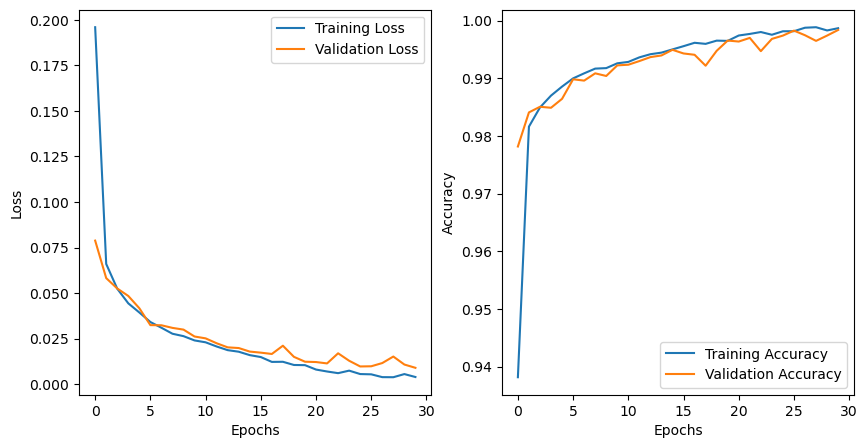

In [9]:
# Load the saved model
loaded_model = load_model(LOADED_MODEL_NAME)

loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(accuracy)
print(loss)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
confusion, cf_report, report, predicted_report, predicted_labels = math_reports(model, X_test, y_test, training_class_labels, training_class_labels)

545/545 [==============================] - 4s 6ms/step


In [11]:
print("Confusion Matrix")
print(confusion)

Confusion Matrix
[[ 265    0    0    0    0    0    0]
 [   0 2596    0    0    4    0    0]
 [   0    0 2619    0    9    0    0]
 [   0    0    0 4535    0    0    0]
 [   0    4    7    0  335    0    0]
 [   0    0    0    2    0 6139    0]
 [   0    1    0    1    0    0  892]]


In [12]:
print("Classification Report")
print(cf_report)

Classification Report
              precision    recall  f1-score   support

           !       1.00      1.00      1.00       265
           (       1.00      1.00      1.00      2600
           )       1.00      1.00      1.00      2628
           +       1.00      1.00      1.00      4535
           ,       0.96      0.97      0.97       346
           -       1.00      1.00      1.00      6141
           0       1.00      1.00      1.00       894

    accuracy                           1.00     17409
   macro avg       0.99      0.99      0.99     17409
weighted avg       1.00      1.00      1.00     17409



In [13]:
print("Confusion Matrix Report")
print(report)

Confusion Matrix Report
Class !: Correct 265/265 | Wrong: 0
Class (: Correct 2596/2600 | Wrong: 4
Class ): Correct 2619/2628 | Wrong: 9
Class +: Correct 4535/4535 | Wrong: 0
Class ,: Correct 335/346 | Wrong: 11
Class -: Correct 6139/6141 | Wrong: 2
Class 0: Correct 892/894 | Wrong: 2



In [14]:
print("Predicted vs Actual")
print(predicted_report)

Predicted vs Actual
Predicted: -, Actual: -, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: 0, Actual: 0, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: 0, Actual: 0, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: +, Actual: +, Result: corr

## 5 Test Model with Unseen Test Data

In [15]:
#load test_images
images_test, labels_test, test_class_labels = pre_processing_from_dir("dataset/test", class_labels_dict)

In [16]:
#Predict using loaded model
confusion_test, cf_report_test, report_test, predicted_report_test, predicted_labels_test = math_reports(LOADED_MODEL_NAME, images_test, labels_test, test_class_labels, training_class_labels)

306/306 [==============================] - 2s 6ms/step


In [17]:
print("Classification Report Test")
print(cf_report_test)

Classification Report Test
              precision    recall  f1-score   support

           !       1.00      1.00      1.00       252
           (       1.00      1.00      1.00      1430
           )       0.99      1.00      0.99      1436
           +       1.00      1.00      1.00      2512
           ,       0.95      0.94      0.94       191
           -       1.00      1.00      1.00      3400
           0       1.00      1.00      1.00       547

    accuracy                           1.00      9768
   macro avg       0.99      0.99      0.99      9768
weighted avg       1.00      1.00      1.00      9768



In [18]:
print("Confusion Matrix Test")
print(confusion_test)

Confusion Matrix Test
[[ 252    0    0    0    0    0    0]
 [   0 1427    0    0    3    0    0]
 [   0    0 1430    0    6    0    0]
 [   0    0    0 2512    0    0    0]
 [   0    1    9    0  180    1    0]
 [   0    0    0    1    1 3398    0]
 [   0    1    0    1    0    0  545]]


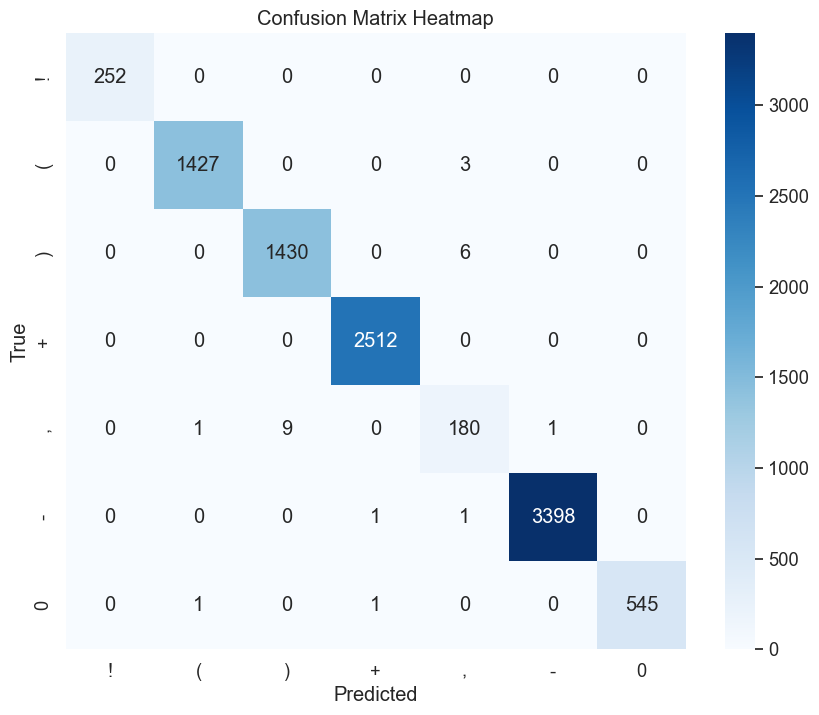

In [19]:
# to better visualize confusion matrix

# Replace this with your class labels
class_labels = [key for key, value in class_labels_dict.items() if value in np.unique(predicted_labels_test)]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [20]:
print("Confusion Matrix Report")
print(report_test)

Confusion Matrix Report
Class !: Correct 252/252 | Wrong: 0
Class (: Correct 1427/1430 | Wrong: 3
Class ): Correct 1430/1436 | Wrong: 6
Class +: Correct 2512/2512 | Wrong: 0
Class ,: Correct 180/191 | Wrong: 11
Class -: Correct 3398/3400 | Wrong: 2
Class 0: Correct 545/547 | Wrong: 2



In [21]:
print("Predicted vs Actual Test")
print(predicted_report_test)

Predicted vs Actual Test
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: